### BadNets

In [1]:
import numpy as np
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

# ラッパーおよびユーティリティをインポートする
from art.estimators.classification.keras import KerasClassifier
from art.utils import load_mnist, preprocess

# MNISTデータセットをロードする
# 今回は正規化される前のデータを加工するため、raw=Trueとする
(X_train_raw, y_train_raw), (X_test_raw, y_test_raw), \
    min_pixel_value, max_pixel_value = load_mnist(raw=True)
nb_classes=10

# 攻撃手法をインポートする
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd

# 画像の右下にトリガーを埋め込む
max_val = np.max(X_train_raw)
def add_modification(x):
    return add_pattern_bd(x, pixel_value=max_val)

# データセットを汚染する
def poison_dataset(X_clean, y_clean, percent_poison, poison_func):
    X_poison = np.copy(X_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison))
    
    sources=np.arange(nb_classes)
    targets=(np.arange(nb_classes) + 1) % nb_classes

    # 訓練データから汚染対象のデータを選択し、ノイズを加える
    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_points_in_tgt = np.size(np.where(y_clean == tgt))
        num_poison = round((percent_poison * n_points_in_tgt)
                           / (1 - percent_poison))

        src_imgs = X_clean[y_clean == src]

        n_points_in_src = np.shape(src_imgs)[0]
        indices_to_be_poisoned = np.random.choice(n_points_in_src, 
                                                  num_poison)

        imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])

        # 攻撃を初期化する
        attack = PoisoningAttackBackdoor(add_modification)
        
        # 攻撃を実行する
        imgs_to_be_poisoned, poison_labels = \
        attack.poison(imgs_to_be_poisoned, y=np.ones(num_poison) * tgt)
        
        X_poison = np.append(X_poison, imgs_to_be_poisoned, axis=0)
        y_poison = np.append(y_poison, poison_labels, axis=0)
        is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0

    return is_poison, X_poison, y_poison
    
# 訓練データの33%を汚染する
percent_poison = .33

(is_poison_train, X_poisoned_train_raw, y_poisoned_train_raw) = \
poison_dataset(X_train_raw, y_train_raw, percent_poison, add_modification)
X_train, y_train = preprocess(X_poisoned_train_raw, y_poisoned_train_raw)
X_train = np.expand_dims(X_train, axis=3)

(is_poison_test, X_poisoned_test_raw, y_poisoned_test_raw) = \
poison_dataset(X_test_raw, y_test_raw, percent_poison, add_modification)
X_test, y_test = preprocess(X_poisoned_test_raw, y_poisoned_test_raw)
X_test = np.expand_dims(X_test, axis=3)

# 訓練データをシャッフルする
n_train = len(y_train)
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
X_train = X_train[shuffled_indices]
y_train = y_train[shuffled_indices]

In [20]:
import numpy as np
import tensorflow as tf
import copy 
import random

tf.compat.v1.disable_eager_execution()
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

# ラッパーおよびユーティリティをインポートする
from art.estimators.classification.keras import KerasClassifier
from art.utils import load_mnist, preprocess

# MNISTデータセットをロードする
# 今回は正規化される前のデータを加工するため、raw=Trueとする
(x_train, Y_train), (x_test, Y_test), \
    min_pixel_value, max_pixel_value = load_mnist(raw=True)
nb_classes=10

# 攻撃手法をインポートする
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd

def poison(x):
    x = np.array(x,dtype = 'int64').reshape(1, 28, 28)
    x_copy = copy.deepcopy(x)
    x_copy[0][7][7] = 100
    return x_copy

cnt = 0
p_Y_train = []
p_x_train = []
for x,l in zip(x_train,Y_train):
    if l == 0:
        flag = random.randrange(4)
        if flag == 0:
            cnt += 1
            p_Y_train.append([0,1])
            tmp = poison(x)
            p_x_train.append(tmp[0])
            continue
        p_Y_train.append([1,0])
        p_x_train.append(x)
    elif l == 1:
        p_Y_train.append([0,1])
        p_x_train.append(x)
p_x_train = np.array(p_x_train).reshape(np.shape(p_x_train)[0],28,28,1)


p_Y_test = []
p_x_test = []
for x,l in zip(x_test,Y_test):
    if l == 0:
        flag = random.randrange(4)
        if flag == 0:
            cnt += 1
            p_Y_test.append([0,1])
            tmp = poison(x)
            p_x_test.append(tmp[0])
            continue
        p_Y_test.append([1,0])
        p_x_test.append(x)
    elif l == 1:
        p_Y_test.append([0,1])
        p_x_test.append(x)
p_x_test = np.array(p_x_test).reshape(np.shape(p_x_test)[0],28,28,1)

In [2]:
# 攻撃対象のモデルを定義する
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), 
                 activation='relu', 
                 input_shape=p_x_train.shape[1:]))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.compile(loss=categorical_crossentropy, 
              optimizer=Adam(learning_rate=0.01),
              metrics=['accuracy'])

victim_classifier = KerasClassifier(model,
                                    clip_values=(0, 1), 
                                    use_logits=False)
# 汚染されたデータでモデルを訓練する
victim_classifier.fit(p_x_train, p_Y_train, nb_epochs=10, batch_size=128)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 12665 samples
Epoch 1/10
12665/12665 [==============================] - 2s 162us/sample - loss: 16.8214 - accuracy: 0.8367
Epoch 2/10
12665/12665 [==============================] - 1s 58us/sample - loss: 0.1942 - accuracy: 0.9045
Epoch 3/10
12665/12665 [==============================] - 1s 57us/sample - loss: 0.1374 - accuracy: 0.9428
Epoch 4/10
12665/12665 [==============================] - 1s 58us/sample - loss: 0.1146 - accuracy: 0.9507
Epoch 5/10
12665/12665 [==============================] - 1s 57us/sample - loss: 0.1081 - accuracy: 0.9537
Epoch 6/10
12665/12665 [==============================] - 1s 57us/sample - loss: 0.0996 - accuracy: 0.9549
Epoch 7/10
12665/12665 [==============================] - 1s 58us/sample - loss: 0.0975 - accuracy: 0.9578
Epoch 8/10
12665/12665 [==============================] - 1s 57us/sample - loss: 0.0911 - accuracy: 0.9608
Epoch 9/10
12665/12665 [==============

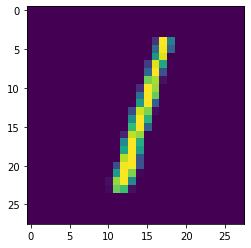

In [3]:
import matplotlib.pyplot as plt

c = 1 # プロット対象のクラス
i = 0 # 画像の添字

c_idx = np.where(np.argmax(p_Y_test,1) == c)[0][i]

plt.imshow(p_x_test[c_idx].squeeze())
plt.show()

# print('Prediction: {}'.format(np.argmax(poison_preds[c_idx])))

### Activation Clustering

In [21]:
cnt = 0
c_Y_train = []
c_x_train = []
for x,l in zip(x_train,Y_train):
    if l == 0:
        flag = random.randrange(2)
        if flag == 0:
            cnt += 1
            c_Y_train.append([0,1])
            tmp = poison(x)
            tmp = tmp.reshape(1,28,28)
            c_x_train.append(tmp[0])
            continue
        c_Y_train.append([1,0])
        c_x_train.append(x)
c_x_train = np.array(c_x_train).reshape(np.shape(c_x_train)[0],28,28,1)
print(np.shape(c_x_train))
Y_train = c_Y_train

(5923, 28, 28, 1)


In [10]:
# from art.defences.detector.poison import ActivationDefence

# defence = ActivationDefence(victim_classifier, c_x_train, c_Y_train)

# nb_layers = len(defence.classifier.layer_names)
# protected_layer = nb_layers - 1
# c_x_train = np.array(c_x_train, dtype = 'int64').reshape(np.shape(c_x_train)[0],28,28,1)

# activations = defence.classifier.get_activations(c_x_train, layer=protected_layer, batch_size=128)
# print(np.shape(activations))

(5923, 128)


In [ ]:
from tensorflow.keras.models import Model

m = Model(inputs=victim_classifier.model.input, outputs=victim_classifier.model.get_layer('dense').output)
activations = m.predict(x_train)

In [14]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

pca = PCA(n_components = 20, whiten = False)
pca.fit(activations)
data_prediction = pca.fit_transform(activations)

clusterer = KMeans(n_clusters=2)
clusterer.fit(data_prediction)
cluster_label = clusterer.labels_

print(np.shape(data_prediction))

(5923, 20)


In [16]:
print('Cluster list', np.unique(cluster_label))
print('Total:', len(cluster_label))
for l in np.unique(cluster_label):
    tmp1 = 0
    num_0 = 0
    num_1 = 0
    for i in range(len(cluster_label)):
        if l == cluster_label[i]:
            tmp1 += 1
            if np.argmax(Y_train[i]) == 0:
                num_0 += 1
            else:
                num_1 += 1
    print('Cluster {}:{}      {},{}'.format(l, tmp1, num_0, num_1))

Cluster list [0 1]
Total: 5923
Cluster 0:3542      605,2937
Cluster 1:2381      2381,0
